In [1]:
import pandas as pd
from pathlib import Path
from getpass import getpass


from helpers_mfq import mfq_part1, mfq_part2

In [2]:
model = "gpt-3.5-turbo"

MFQ INFO

In [3]:
# questions1 = [q for q in mfq_part1.split("\n\n")[2].split("\n") if q]
# questions2 = [q for q in mfq_part2.split("\n\n")[2].split("\n") if q]

questions1_item_key = [
    ("emotionally", "care"),
    ("treated", "fairness"),
    ("lovecountry", "loyalty"),
    ("respect", "authority"),
    ("decency", "sanctity"),
    ("math", None),
    ("weak", "care"),
    ("unfairly", "fairness"),
    ("betray", "loyalty"),
    ("traditions", "authority"),
    ("disgusting", "sanctity"),
    ("cruel", "care"),
    ("rights", "fairness"),
    ("loyalty", "loyalty"),
    ("chaos", "authority"),
    ("god", "sanctity"),
]

questions2_item_key = [
    ("compassion", "care"),
    ("fairly", "fairness"),
    ("history", "loyalty"),
    ("kidrespect", "authority"),
    ("harmlessdg", "sanctity"),
    ("good", None),
    ("animal", "care"),
    ("justice", "fairness"),
    ("family", "loyalty"),
    ("sexroles", "authority"),
    ("unnatural", "sanctity"),
    ("kill", "care"),
    ("rich", "fairness"),
    ("team", "loyalty"),
    ("soldier", "authority"),
    ("chastity", "sanctity"),
]

Analysing data


In [4]:
from pathlib import Path
df_chat = pd.concat(
    map(pd.read_csv, Path("data/mfq").glob("*3.5-turbo*.csv")),
)

In [5]:
df_chat.groupby("condition")["math"].value_counts()

condition  math
after      2       67
           1       54
           0        4
           3        1
before     0       64
           1       63
           2        2
Name: math, dtype: int64

In [6]:
df_chat.groupby("condition")["good"].value_counts()

condition  good
after      5       75
           4       51
before     4       65
           5       64
Name: good, dtype: int64

Filtering rows based on control questions - only one case was filtered out

In [7]:
df_chat.query("math < 3 and good > 2", inplace=True)

# drop cols
df_chat.drop(columns=["math", "good"], inplace=True)

# Compare before and after distributions

In [8]:
import numpy as np
def cohen_d(x,y):
        from math import sqrt
        std_factor = sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
        if std_factor == 0:
            return np.nan
        return (np.mean(x) - np.mean(y))


def compare_subsets_distributions(df_before, df_randomized):
    import scipy.stats
    from scipy.stats import mannwhitneyu
    from statsmodels.stats.multitest import multipletests
    test_results = list()

    for code in df_before.columns:
        ordered_answers = df_before[code]

        randomized_answer = df_randomized[code]
        if df_randomized[str(code)].nunique() < 3 or df_before[str(code)].nunique() < 3:
            print(
                f"Code: {code} had {df_before[str(code)].nunique()} different answers when generated in before"
            )
            print(
                f"Code: {code} had {df_randomized[str(code)].nunique()} different answers when generated in after"
            )

        test_results.append(
            (
                code,
                np.median(ordered_answers),
                scipy.stats.median_abs_deviation(ordered_answers),
                np.median(randomized_answer),
                scipy.stats.median_abs_deviation(randomized_answer),
                cohen_d(ordered_answers, randomized_answer),
                *mannwhitneyu(ordered_answers, randomized_answer),
            )
        )

    df_tests = pd.DataFrame(
        test_results,
        columns=["mfv_code", "mediana_ordered", "MAD_ordered", "mediana_randomized", "MAD_randomized", "cohen_d", "u", "p-value"],
    )
    df_tests["rejected"], df_tests["adjusted_p-value"], _, _ = multipletests(
        df_tests["p-value"],
        alpha=0.05,
        method="bonferroni"
    )
    # round adjusted p-value to 3 decimals
    df_tests["adjusted_p-value"] = df_tests["adjusted_p-value"].apply(lambda x: round(x, 4))

    df_tests["median_dif"] = df_tests["mediana_ordered"] - df_tests["mediana_randomized"]
    return df_tests

In [9]:
before_after_comparison = compare_subsets_distributions(
    df_chat.query("condition == 'before'").drop(columns=["id", "condition"]),
    df_chat.query("condition == 'after'").drop(columns=["id", "condition"]),
)

Code: treated had 1 different answers when generated in before
Code: treated had 2 different answers when generated in after
Code: weak had 2 different answers when generated in before
Code: weak had 3 different answers when generated in after
Code: unfairly had 2 different answers when generated in before
Code: unfairly had 3 different answers when generated in after
Code: cruel had 2 different answers when generated in before
Code: cruel had 2 different answers when generated in after
Code: loyalty had 2 different answers when generated in before
Code: loyalty had 3 different answers when generated in after
Code: fairly had 2 different answers when generated in before
Code: fairly had 2 different answers when generated in after
Code: history had 2 different answers when generated in before
Code: history had 2 different answers when generated in after
Code: kidrespect had 2 different answers when generated in before
Code: kidrespect had 2 different answers when generated in after
Code

In [10]:
before_after_comparison["rejected"].value_counts()

False    75
True     23
Name: rejected, dtype: int64

In [11]:
before_after_comparison.query("rejected == True")

,mfv_code,mediana_ordered,MAD_ordered,mediana_randomized,MAD_randomized,cohen_d,u,p-value,rejected,adjusted_p-value,median_dif
2,lovecountry,2.0,0.0,2.0,0.0,0.300093,10305.0,4.861563e-07,True,0.0000,0.0
4,decency,4.0,0.0,4.0,0.0,0.267969,10086.5,4.692484e-06,True,0.0005,0.0
8,traditions,4.0,0.0,4.0,0.0,0.263194,10043.5,4.772525e-05,True,0.0047,0.0
9,disgusting,4.0,0.0,3.0,1.0,0.627721,11730.0,2.827444e-13,True,0.0000,1.0
11,rights,4.0,0.0,4.0,0.0,-0.328992,5475.5,1.048224e-09,True,0.0000,0.0
14,god,4.0,0.0,4.0,1.0,-0.410543,5445.0,7.281305e-07,True,0.0001,0.0
19,harmlessdg,3.0,0.0,3.0,0.0,0.266791,9850.5,2.390521e-04,True,0.0234,0.0
21,justice,5.0,0.0,5.0,0.0,-0.226109,6239.5,1.208119e-04,True,0.0118,0.0
22,family,4.0,0.0,4.0,0.0,0.206202,9737.5,3.303391e-04,True,0.0324,0.0
23,sexroles,3.0,0.0,3.0,0.0,0.279504,10109.0,1.047888e-05,True,0.0010,0.0


In [12]:
before_after_comparison.query("rejected == True")["median_dif"].describe()

count    23.000000
mean     -0.086957
std       0.417029
min      -1.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: median_dif, dtype: float64

In [13]:
# make a dictionary with the second value of elements in questions1_item_key as keys and the first value as values. Repeated keys should generate a list of values
questions_dict = {}
for i in questions1_item_key + questions2_item_key:
    if i[1] is None:
        continue
    if i[1] in questions_dict:
        questions_dict[i[1]].append(i[0])
    else:
        questions_dict[i[1]] = [i[0]]



# Generating alphas

In [14]:
alphas = []

# Cronbach for MFQ foundations

Create dataframe for comparative analysis

In [15]:
df = pd.DataFrame()

df["id"] = df_chat["id"]
df["condition"] = df_chat["condition"]

In [16]:
from pingouin import cronbach_alpha

Intervals represent 95% CI

In [17]:
for foundation, questions in questions_dict.items():
    df[f"MFQ_{foundation.lower()}"] = df_chat[questions].mean(axis=1)
    print(f"Cronbach for {foundation.upper()}:", cronbach_alpha(df_chat[questions]))
    alphas.append(
        ["MFQ", foundation.title(), "overall", cronbach_alpha(df_chat[questions])[0]]
    )
    # cronbach para before
    print(
        "Before condition:",
        cronbach_alpha(df_chat.query("condition == 'before'")[questions])
    )
    alphas.append(
        ["MFQ", foundation.title(), "before", cronbach_alpha(df_chat.query("condition == 'before'")[questions])[0]]
    )
    # after
    print(
        "After condition:",
        cronbach_alpha(df_chat.query("condition == 'after'")[questions])
    )
    alphas.append(
        ["MFQ", foundation.title(), "after", cronbach_alpha(df_chat.query("condition == 'after'")[questions])[0]]
    )

Cronbach for CARE: (0.4877060109872523, array([0.384, 0.579]))
Before condition: (0.5216182619505032, array([0.381, 0.639]))
After condition: (0.47236119585112857, array([0.315, 0.604]))
Cronbach for FAIRNESS: (0.48617440295158776, array([0.382, 0.578]))
Before condition: (0.23681632653061227, array([0.013, 0.424]))
After condition: (0.542077505159367, array([0.405, 0.656]))
Cronbach for LOYALTY: (0.422390931381061, array([0.305, 0.526]))
Before condition: (0.27404991491775393, array([0.061, 0.452]))
After condition: (0.49899639096257487, array([0.35 , 0.624]))
Cronbach for AUTHORITY: (0.3424177462950878, array([0.209, 0.46 ]))
Before condition: (0.3663433559650821, array([0.181, 0.522]))
After condition: (0.3422494974076819, array([0.146, 0.506]))
Cronbach for SANCTITY: (0.5049998429697563, array([0.404, 0.594]))
Before condition: (0.4340952661849286, array([0.268, 0.573]))
After condition: (0.5903218743157432, array([0.468, 0.692]))


Generate histogram for each foundation

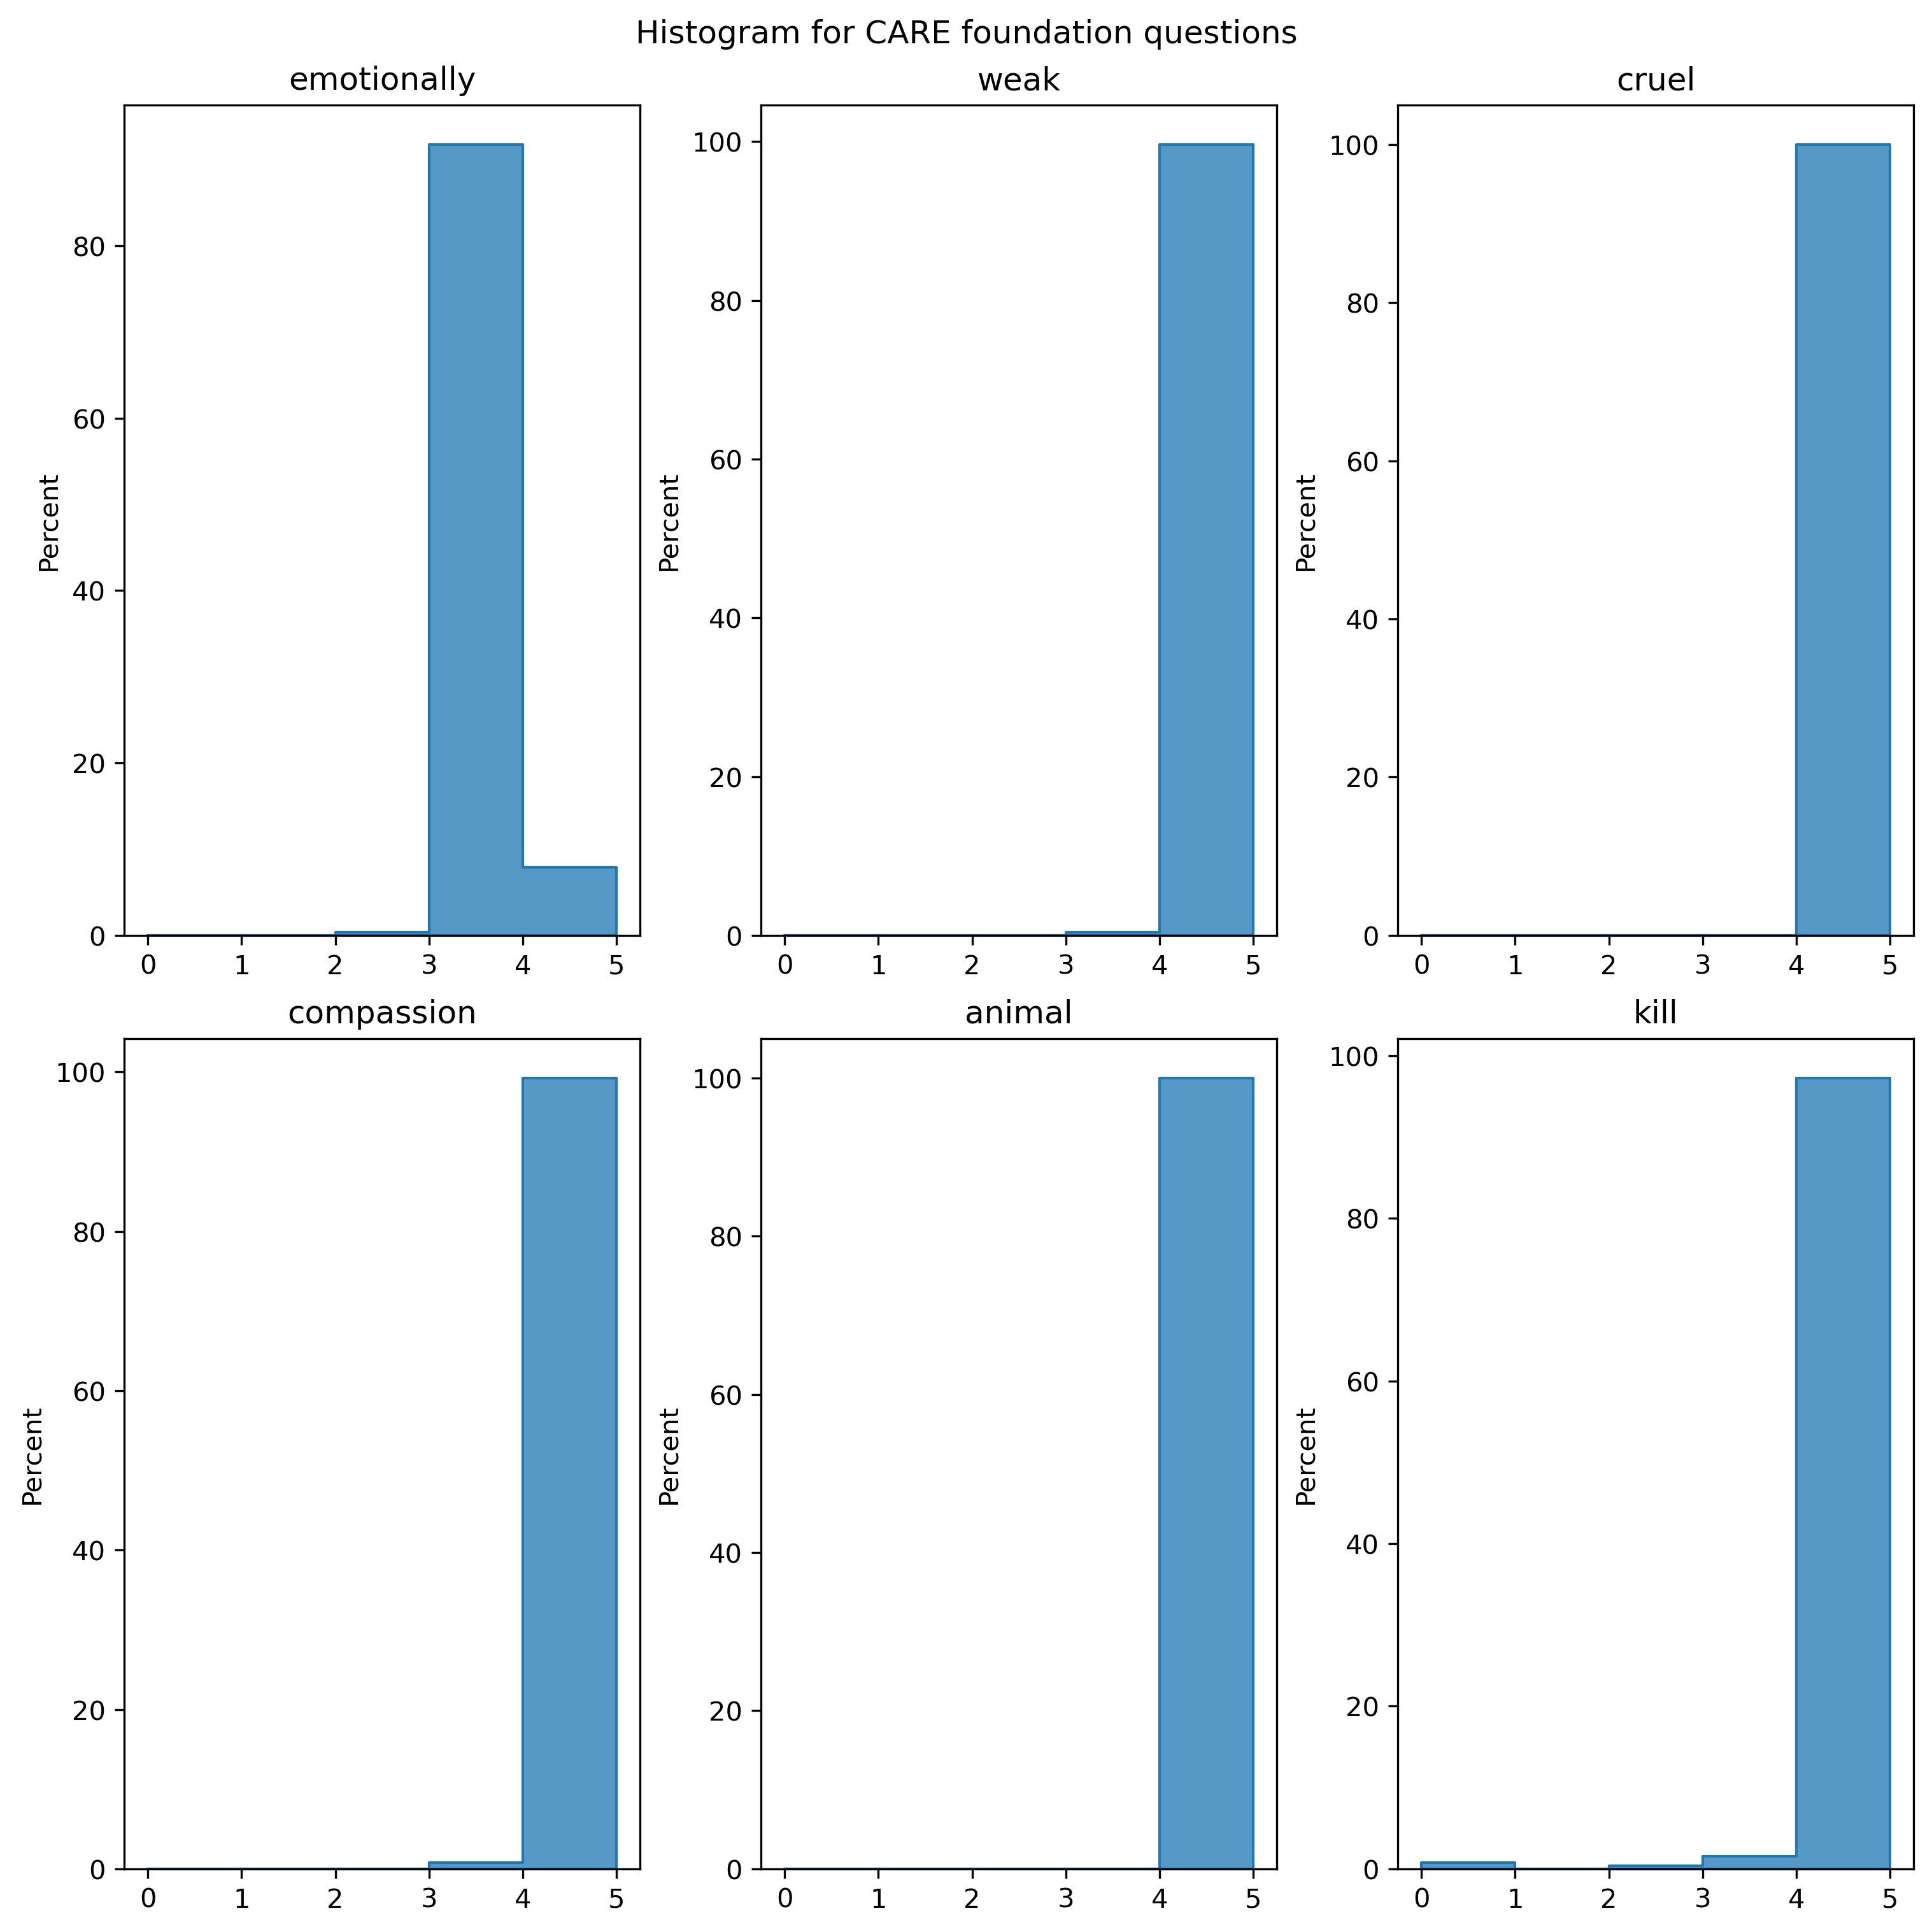

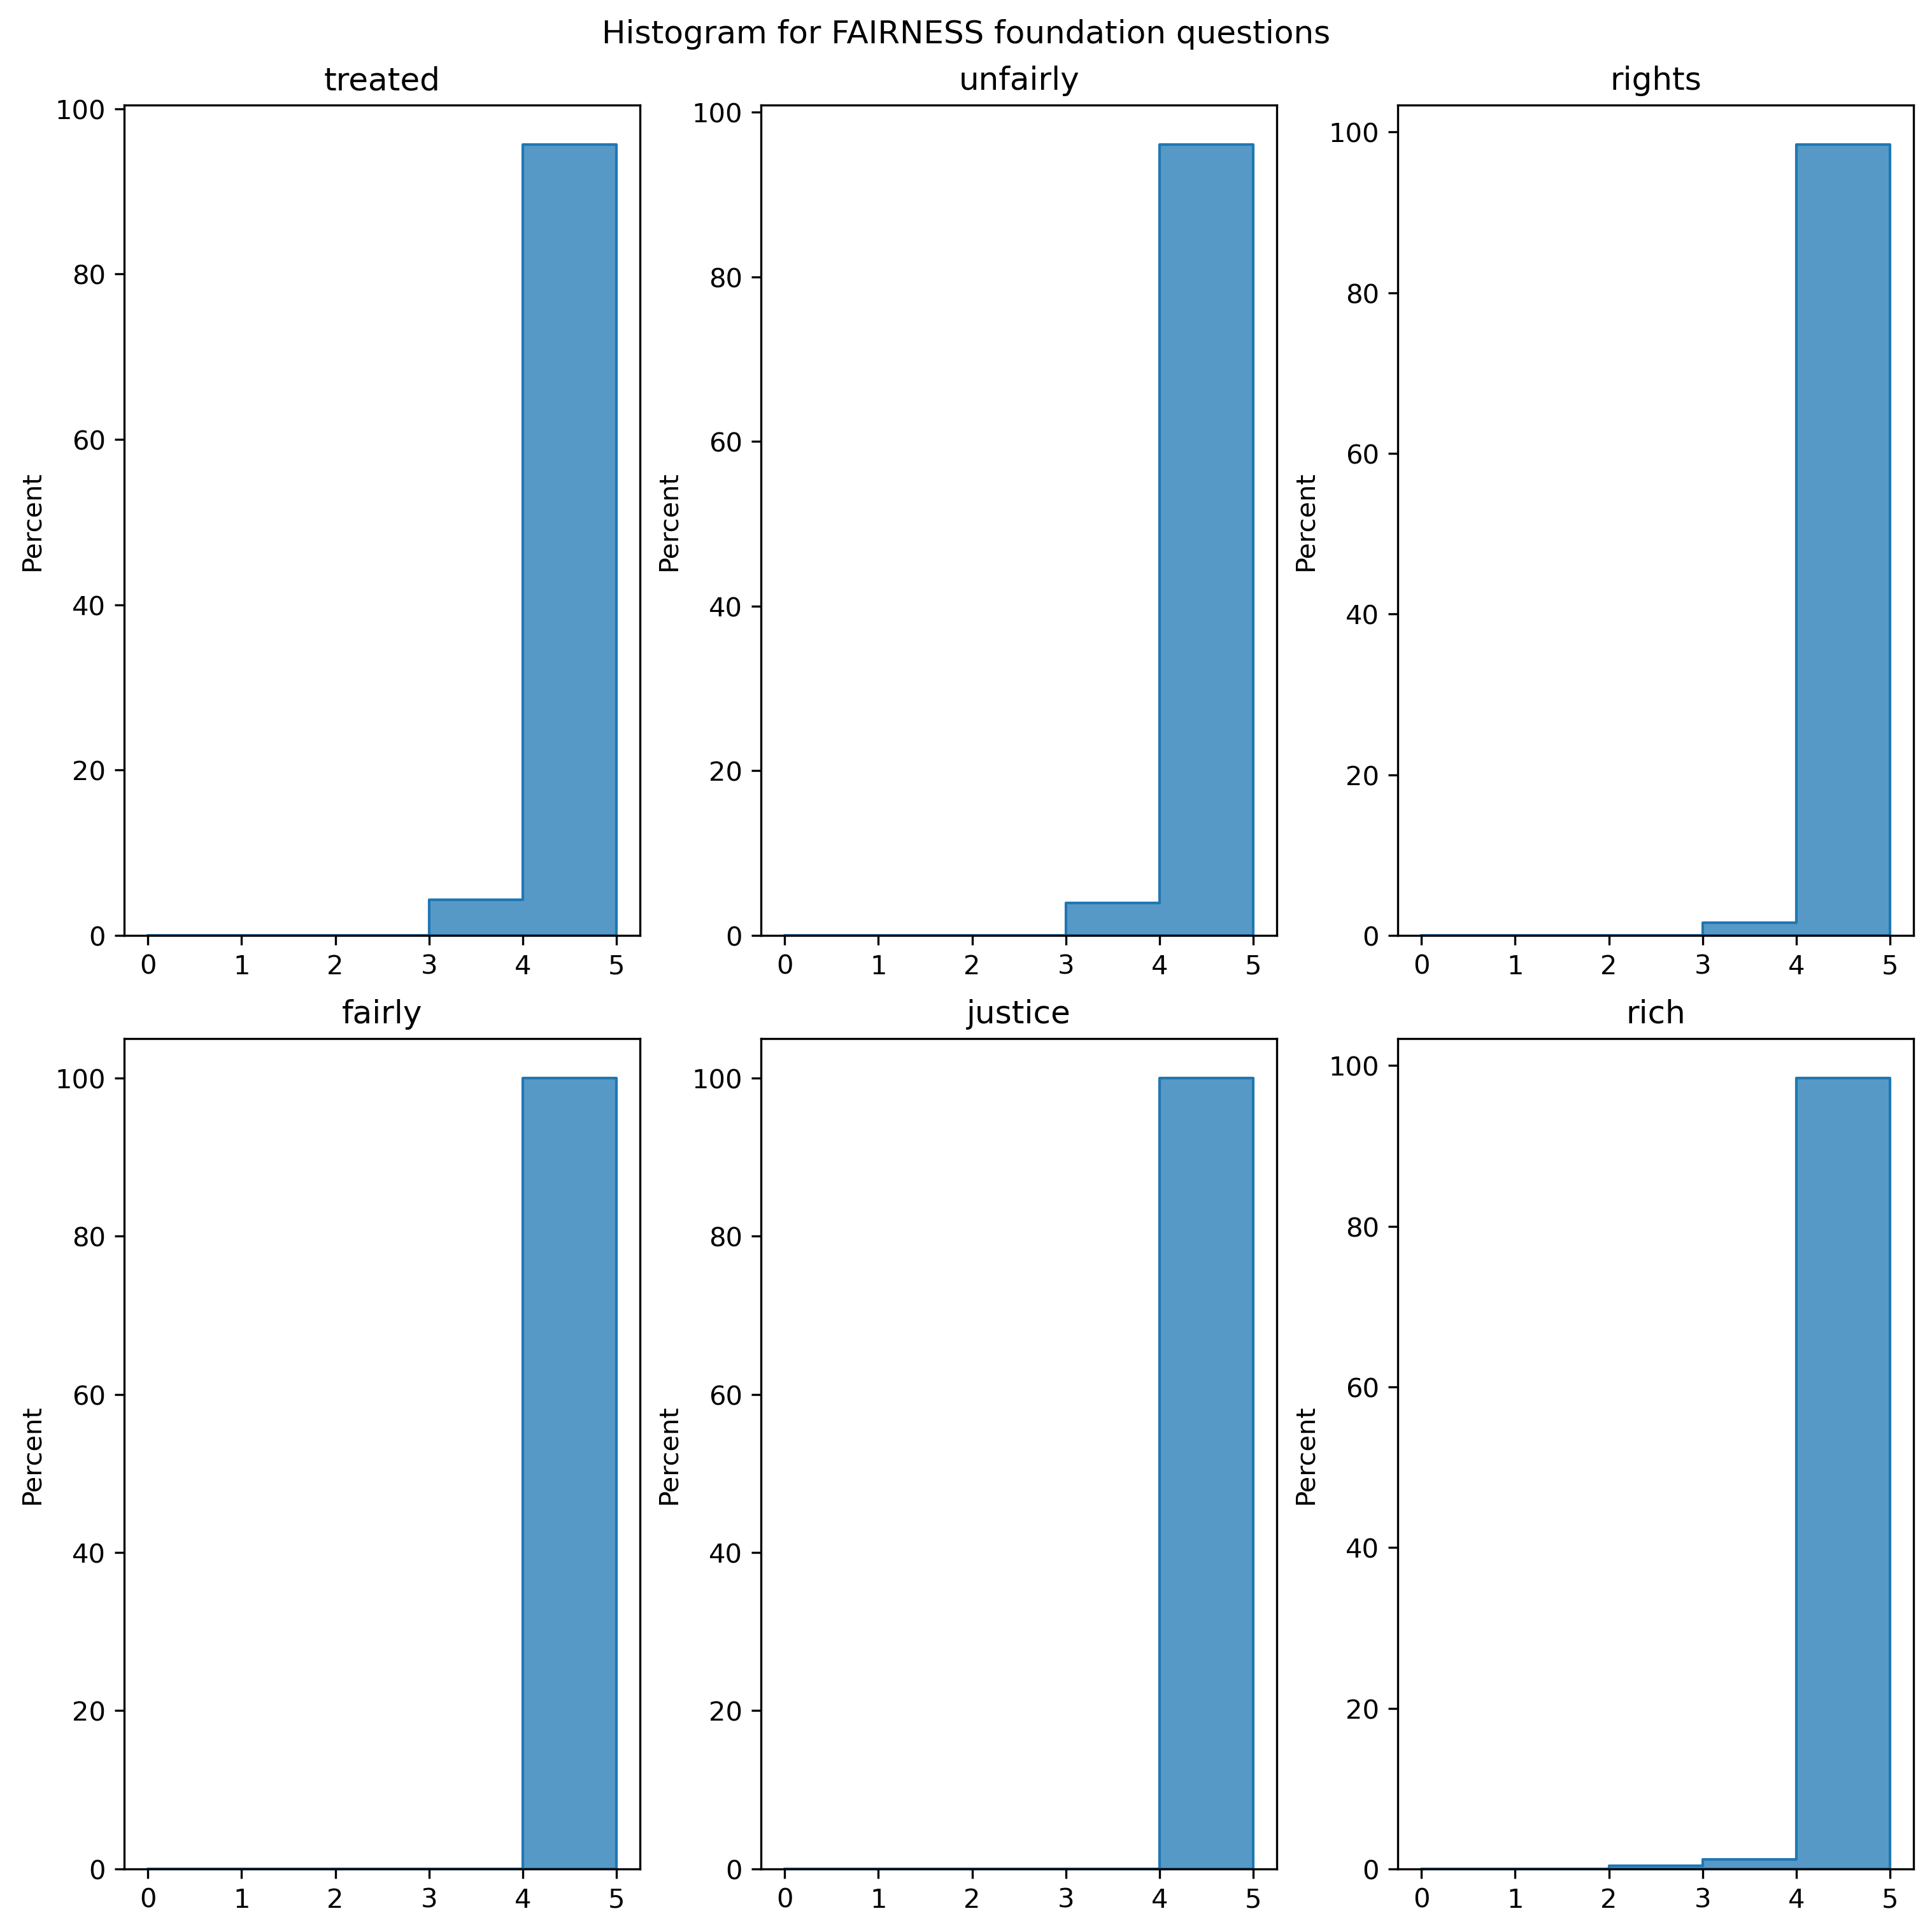

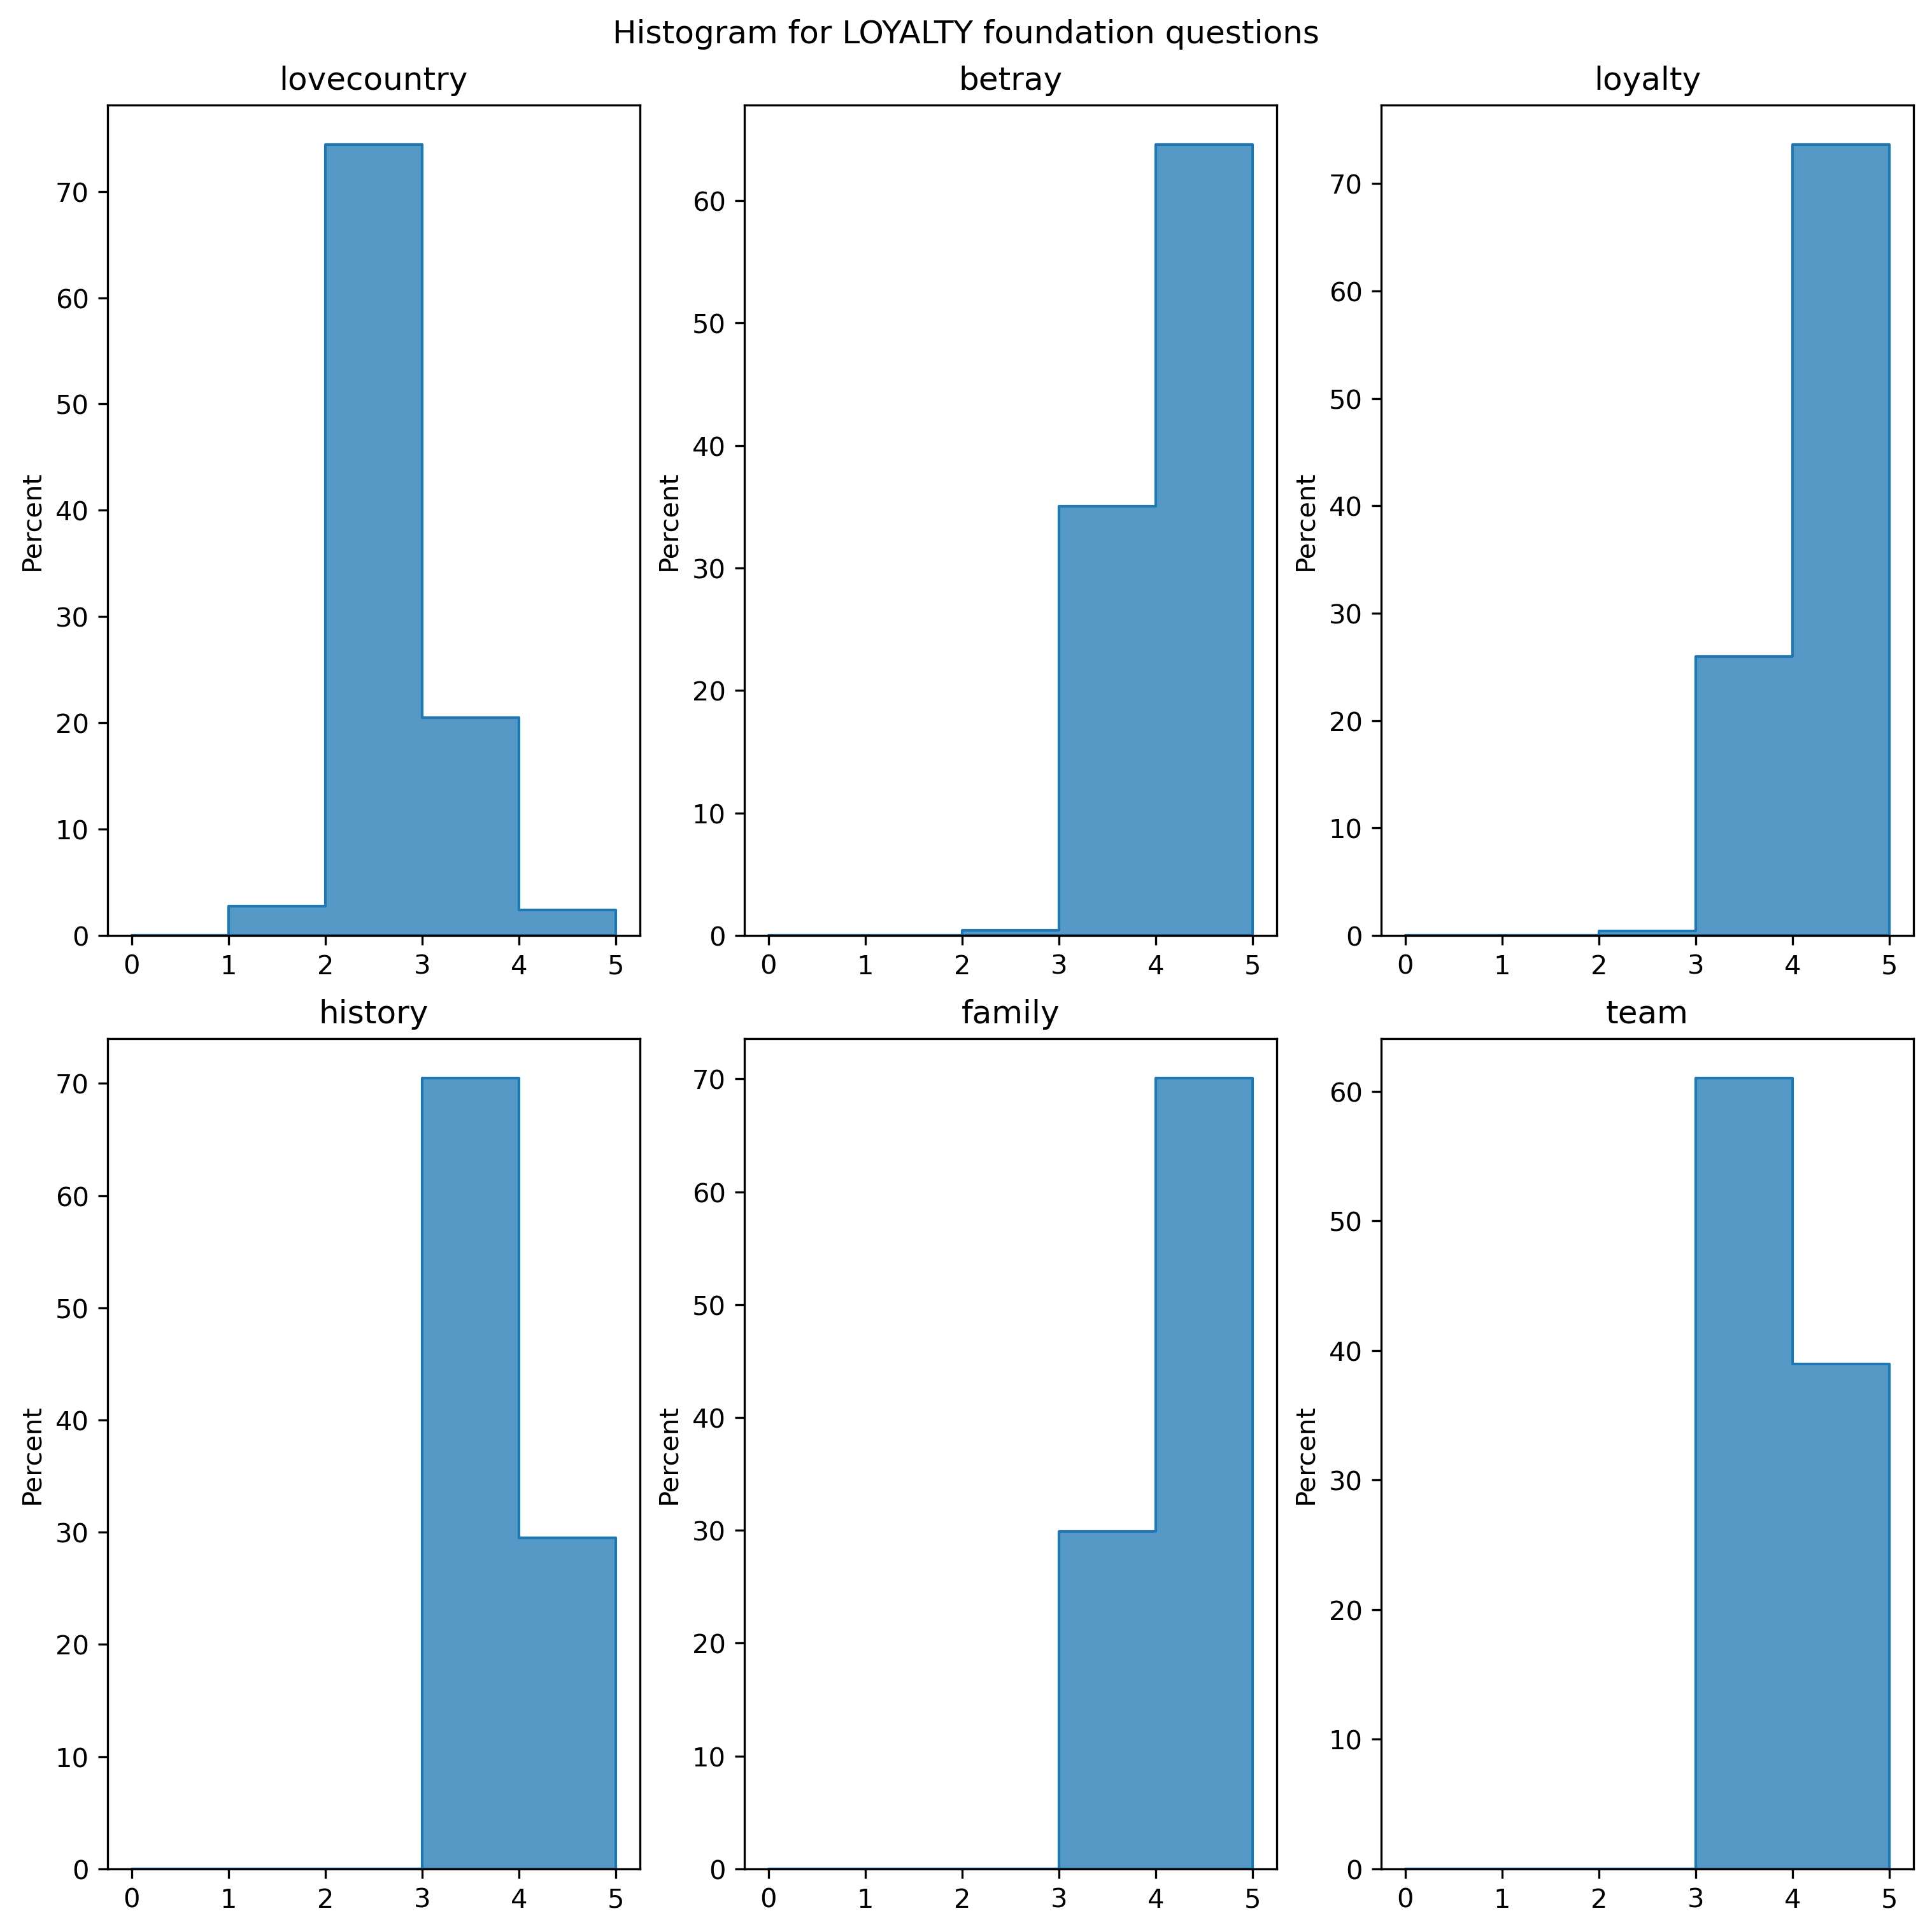

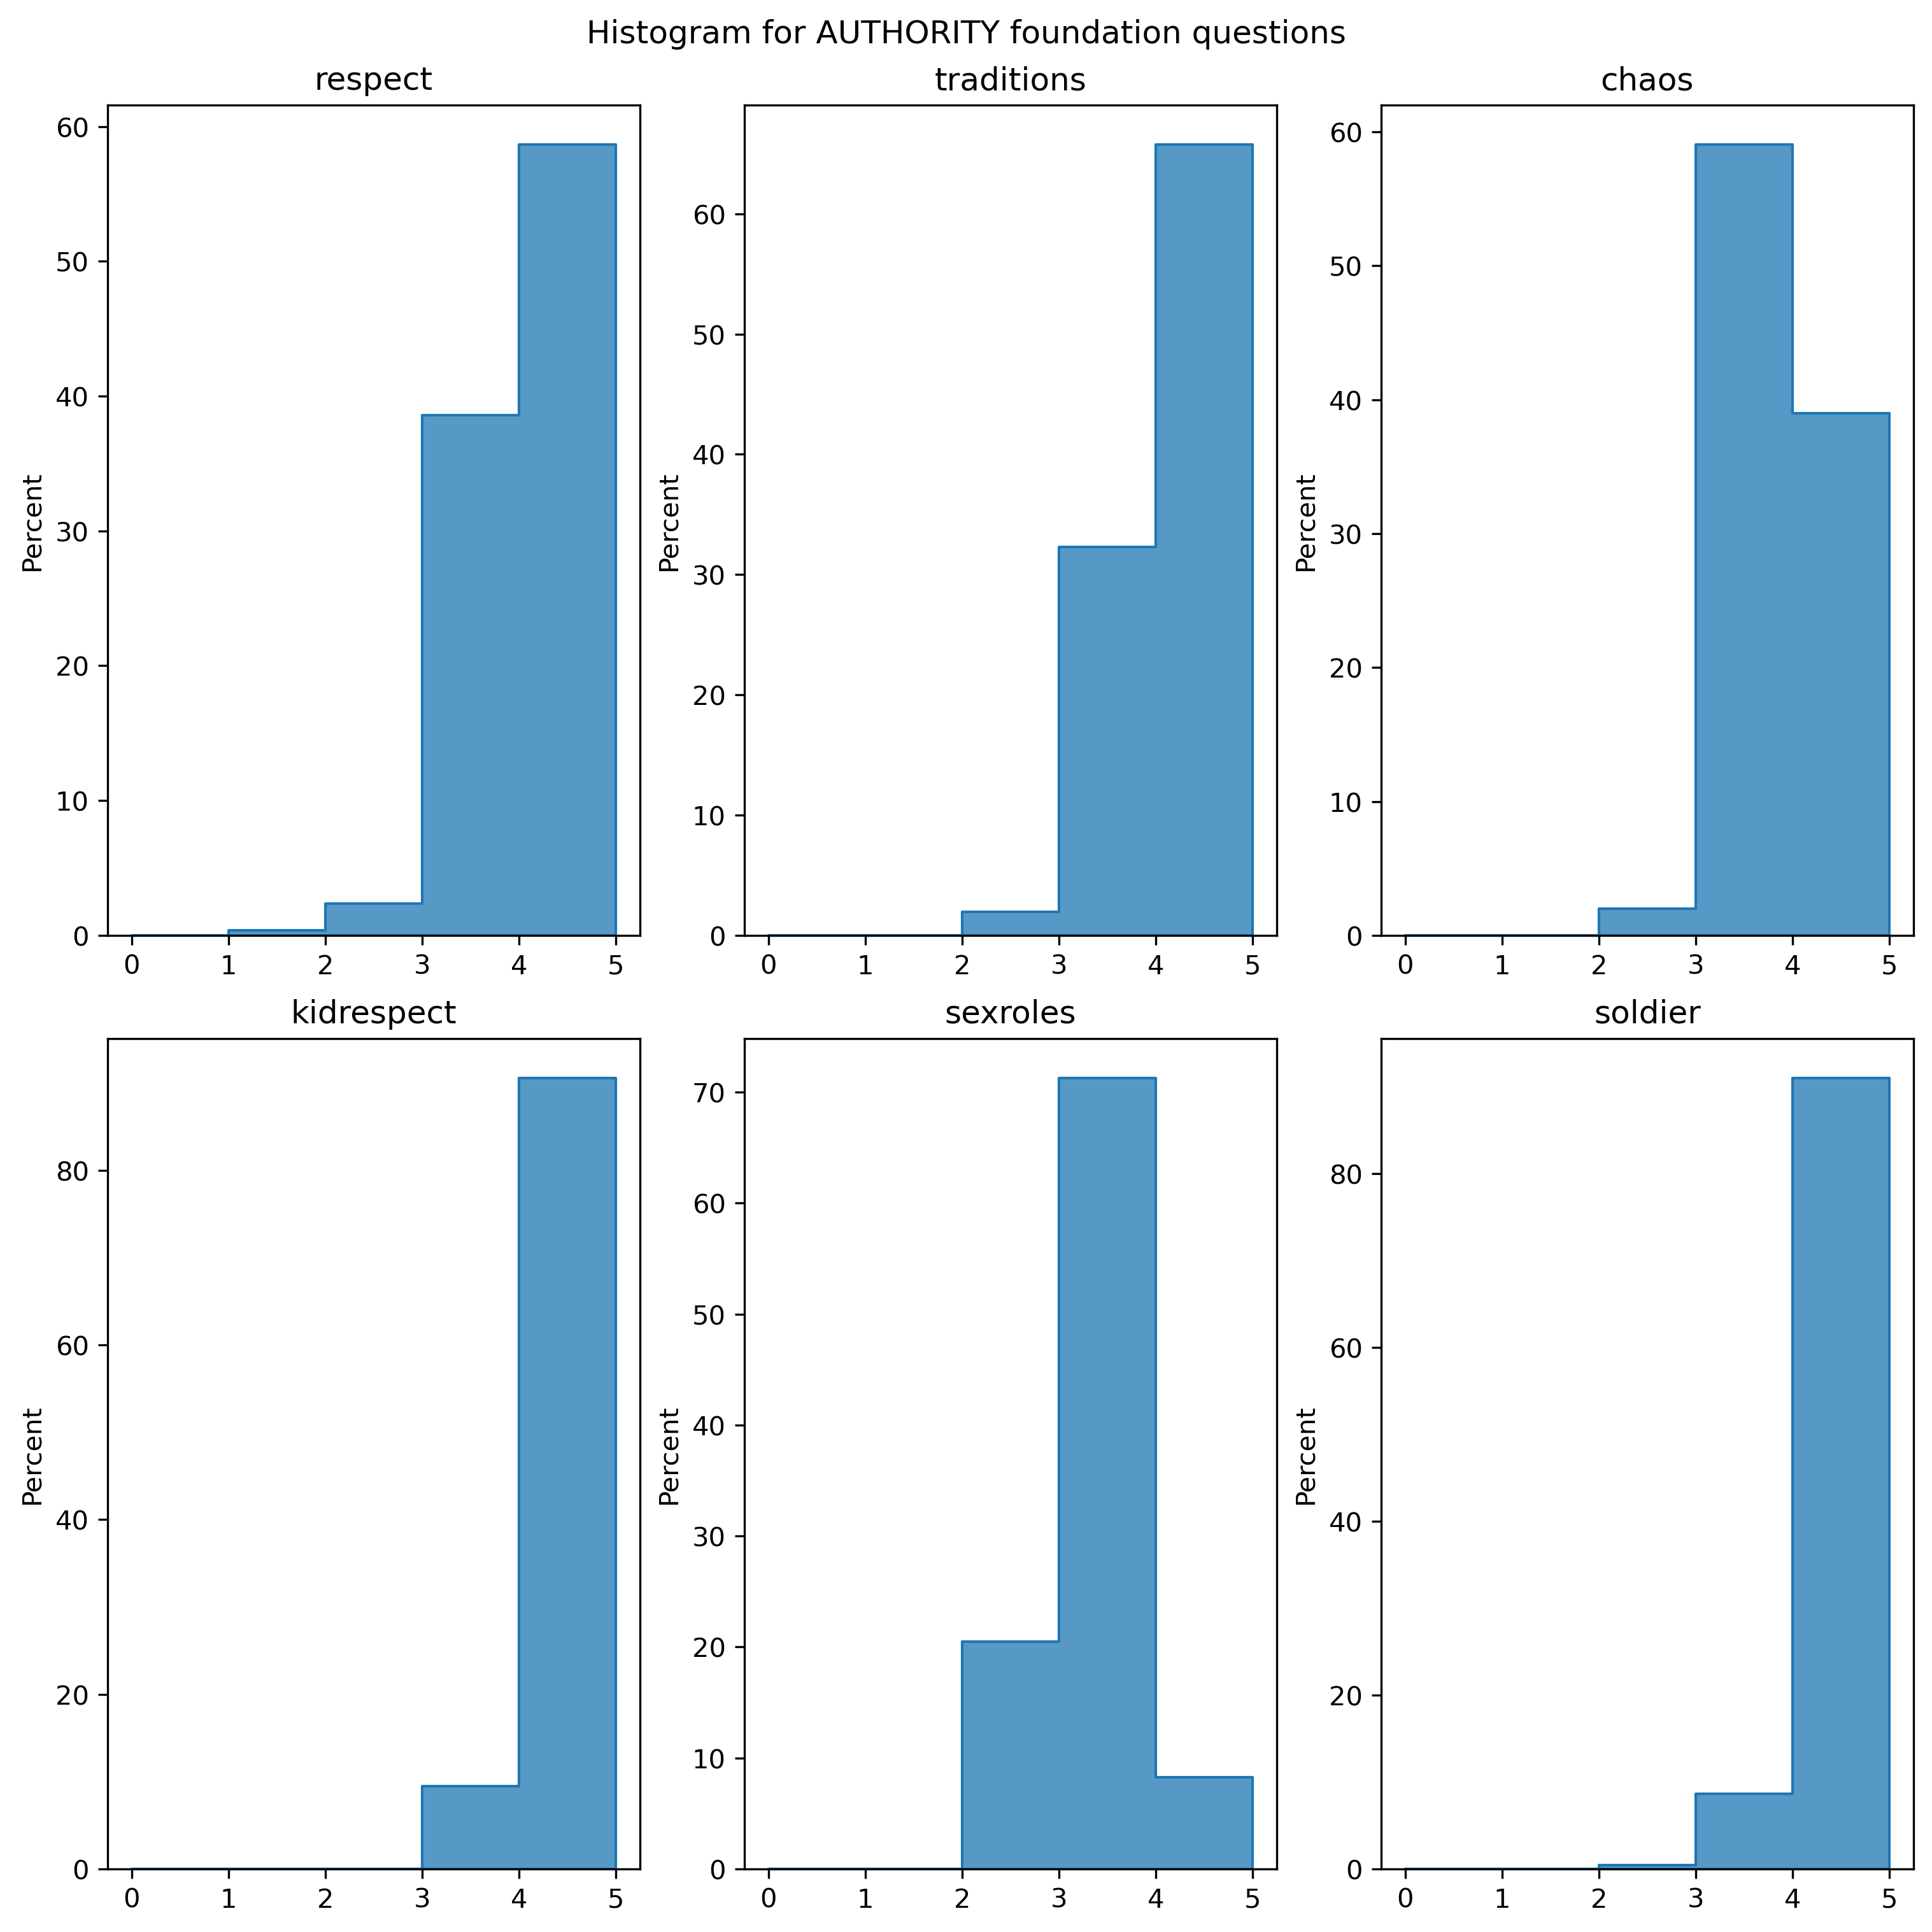

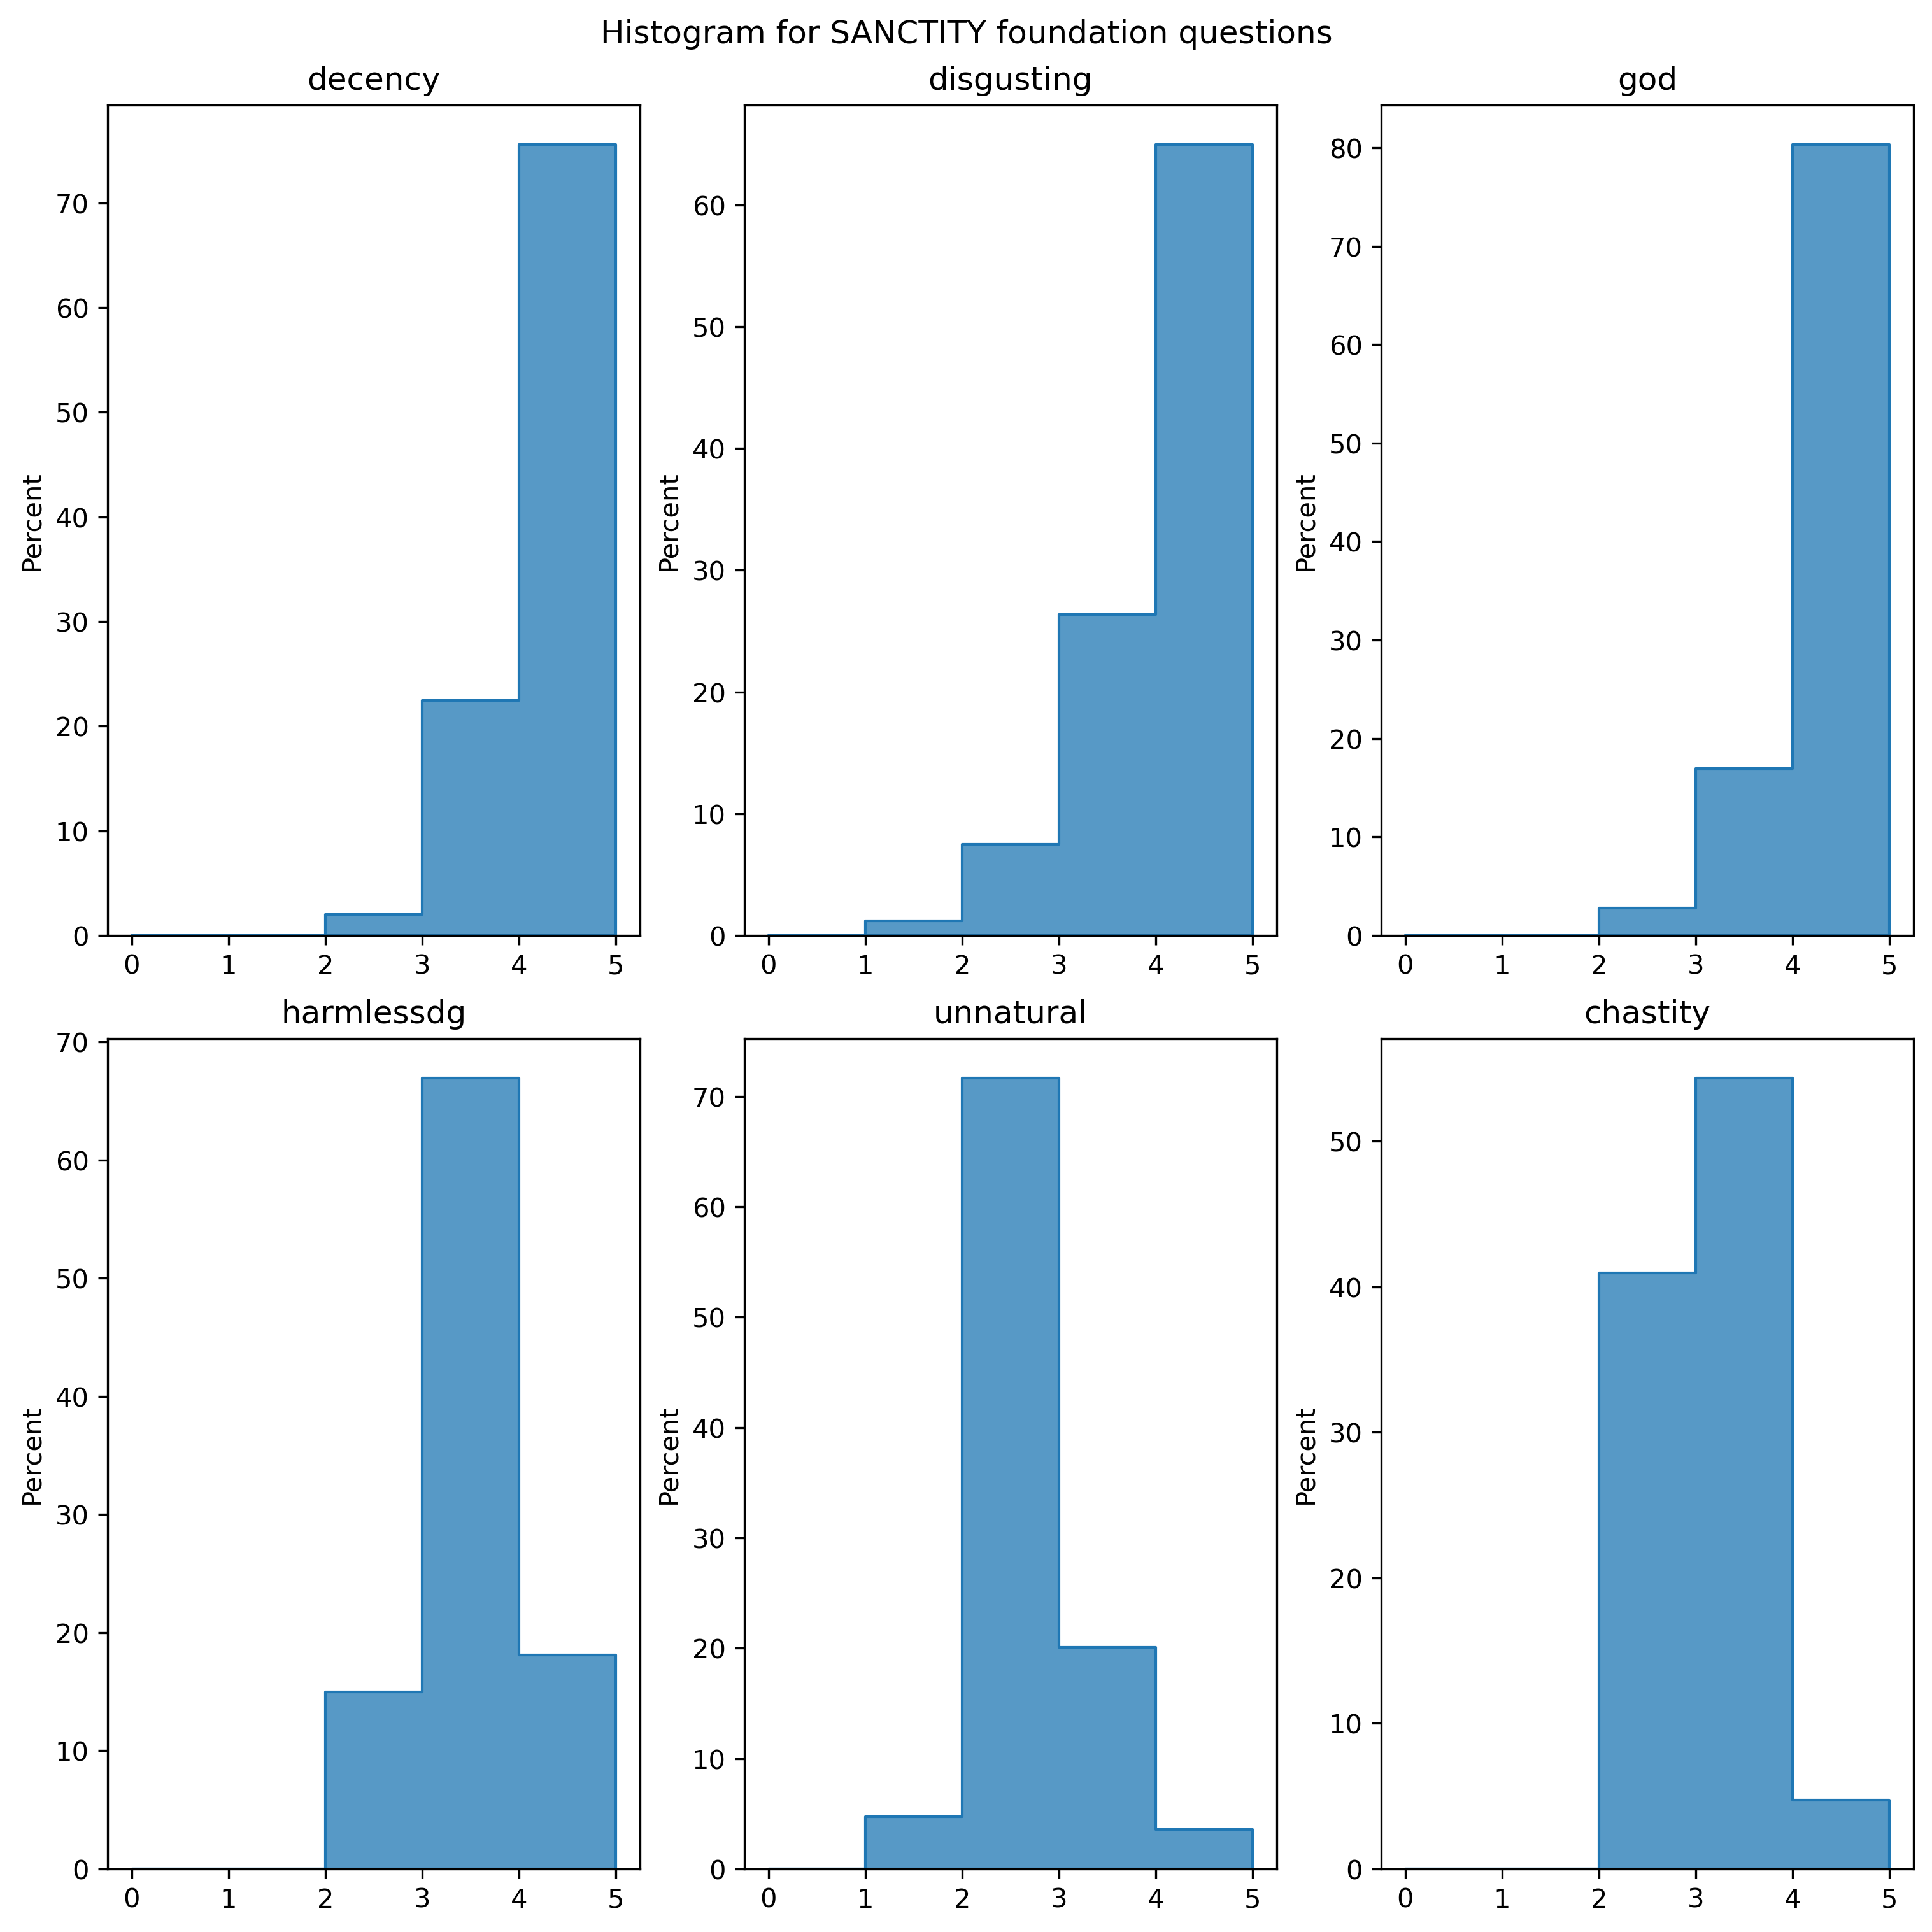

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
# create a histogram for each question in each foundation
for foundation, questions in questions_dict.items():
    fig, axs = plt.subplots(figsize=(10, 10), constrained_layout=True, dpi=300, nrows=2, ncols=3)
    plt.suptitle(f"Histogram for {foundation.upper()} foundation questions")
    for i, question in enumerate(questions):
        ax = axs[i // 3, i % 3]
        sns.histplot(
            data=df_chat,
            x=question,
            color="tab:blue",
            bins=[0,1,2,3,4,5],
            # palette="colorblind",
            # hue="condition",
            # multiple="layer",
            element="step",
            stat="percent",
            ax=ax,
            legend=False,
        )
        ax.set_xlabel("")
        ax.set_title(question)


# Calculate cronbach per foundation in MFV

Loading data to obtain foundation per vignette

In [19]:
from helpers import original_validated
x = original_validated.copy()

In [20]:
# replace 'Care (p,a)' with 'Care (p)' and 'Care (p,h)' with 'Care (p)'
original_validated["Foundation"] = original_validated["Foundation"].replace(
    {
        "Care (p,a)": "Care (p)",
        "Care (p,h)": "Care (p)",
    },
)

Calculate cronbach per foundation in MFVs

In [21]:
print("Calculation internal consistency for MFV")
for f in original_validated["Foundation"].unique():
    codes = original_validated.query("Foundation == @f")["mfv_code"].astype(str).unique().tolist()
    print(f"Cronbach for {f.upper()}:", cronbach_alpha(df_chat[codes]))
    alphas.append(
        ["MFV", f.title(), "overall", cronbach_alpha(df_chat[codes])[0]]
    )
    # cronbach before
    print(
        "Before condition:",
        cronbach_alpha(df_chat.query("condition == 'before'")[codes])
    )
    alphas.append(
        ["MFV", f.title(), "before", cronbach_alpha(df_chat.query("condition == 'before'")[codes])[0]]
    )
    # after
    print(
        "After condition:",
        cronbach_alpha(df_chat.query("condition == 'after'")[codes])
    )
    alphas.append(
        ["MFV", f.title(), "after", cronbach_alpha(df_chat.query("condition == 'after'")[codes])[0]]
    )
    # also add mean to df_chat
    df[f"MFV_{f.title()}"] = df_chat[codes].mean(axis=1)
    

Calculation internal consistency for MFV
Cronbach for CARE (E): (0.832471581613244, array([0.8  , 0.861]))
Before condition: (0.7421808750109193, array([0.671, 0.804]))
After condition: (0.9055607220243466, array([0.879, 0.928]))
Cronbach for CARE (P): (0.8531155694122498, array([0.824, 0.879]))
Before condition: (0.9010384235009707, array([0.873, 0.925]))
After condition: (0.7851285936494314, array([0.724, 0.837]))
Cronbach for FAIRNESS: (0.8136157743870667, array([0.777, 0.846]))
Before condition: (0.8234856647615478, array([0.774, 0.866]))
After condition: (0.7981196501877893, array([0.74 , 0.847]))
Cronbach for LIBERTY: (0.9258053000167106, array([0.911, 0.939]))
Before condition: (0.941376430675167, array([0.925, 0.956]))
After condition: (0.888562244301578, array([0.856, 0.916]))
Cronbach for AUTHORITY: (0.8822714256880221, array([0.859, 0.903]))
Before condition: (0.8675798090358471, array([0.831, 0.899]))
After condition: (0.8904935224832292, array([0.859, 0.917]))
Cronbach for

In [22]:
alphas_df = pd.DataFrame(alphas, columns=["scale", "foundation", "condition", "alpha"])
alphas_df["model"] = model
alphas_df.to_csv(f"data/{model}_cronbach.csv", index=False, encoding="utf-8-sig")

# Regressing for after condition - MFV from MFQ

In [23]:
df.columns

Index(['id', 'condition', 'MFQ_care', 'MFQ_fairness', 'MFQ_loyalty',
       'MFQ_authority', 'MFQ_sanctity', 'MFV_Care (E)', 'MFV_Care (P)',
       'MFV_Fairness', 'MFV_Liberty', 'MFV_Authority', 'MFV_Loyalty',
       'MFV_Sanctity'],
      dtype='object')

Standardizing variables

In [24]:
# standardize the scores
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[df.columns[2:]] = scaler.fit_transform(df[df.columns[2:]])

In [25]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

In [26]:
formula = "Q('{}') ~ MFQ_care + MFQ_fairness + MFQ_loyalty + MFQ_authority + MFQ_sanctity"

dependents = [x for x in df.columns if x.startswith("MFV_")]

Running models

In [39]:
models = list()

for i in dependents:
    mod = smf.ols(formula=formula.format(i), data=df.query("condition == 'after'"))
    res = mod.fit()
    models.append(res)

output = summary_col(models, stars=True)

print(output)


               Q('MFV_Care (E)') Q('MFV_Care (P)') Q('MFV_Fairness') Q('MFV_Liberty') Q('MFV_Authority') Q('MFV_Loyalty') Q('MFV_Sanctity')
-------------------------------------------------------------------------------------------------------------------------------------------
Intercept      0.2477**          0.1295            0.1962**          0.0505           0.2328**           0.2676***        -0.0151          
               (0.1051)          (0.0787)          (0.0850)          (0.0747)         (0.0960)           (0.0759)         (0.0694)         
MFQ_care       0.0284            -0.0108           -0.0703           0.0052           0.0306             0.0308           0.0347           
               (0.1029)          (0.0770)          (0.0832)          (0.0732)         (0.0940)           (0.0743)         (0.0679)         
MFQ_fairness   -0.1725*          0.0084            -0.0910           -0.0309          -0.0893            0.0384           0.1495**         
               (0.0

In [41]:
print(output.as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{llllllll}
\hline
               & Q('MFV\_Care (E)') & Q('MFV\_Care (P)') & Q('MFV\_Fairness') & Q('MFV\_Liberty') & Q('MFV\_Authority') & Q('MFV\_Loyalty') & Q('MFV\_Sanctity')  \\
\hline
Intercept      & 0.2477**           & 0.1295             & 0.1962**           & 0.0505            & 0.2328**            & 0.2676***         & -0.0151             \\
               & (0.1051)           & (0.0787)           & (0.0850)           & (0.0747)          & (0.0960)            & (0.0759)          & (0.0694)            \\
MFQ\_care      & 0.0284             & -0.0108            & -0.0703            & 0.0052            & 0.0306              & 0.0308            & 0.0347              \\
               & (0.1029)           & (0.0770)           & (0.0832)           & (0.0732)          & (0.0940)            & (0.0743)          & (0.0679)            \\
MFQ\_fairness  & -0.1725*           & 0.0084             & -0.0910            & -0.030

# Regressing on Factors

In [29]:
from helper_factor_analysis import run_factor_analysis

In [30]:
codes_vignettes = original_validated["mfv_code"].astype(str).unique()

Saving factor loading to investigate its coherence.

Saving was commented to run some visual highlighting on excel file.

ML method takes a couple dozen seconds to run

In [31]:
factor_df, factor_model = run_factor_analysis(df_chat[codes_vignettes], n_factors=7, method="ml", return_model=True)

# factor_df.to_excel(f"data/final/factor_analysis_{model}.xlsx")

KMO: 0.8798719718710561


/home/joseluiz/anaconda3/envs/eda/lib/python3.10/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


Cumulative variance explained by 7 factors: 0.5088972841824115
Variance: [0.1153553  0.10206235 0.07344657 0.06735385 0.05077306 0.05029874
 0.04960741]


In [32]:
factor_cols = [f"Factor_{i}" for i in range(1, 8)]
df_with_factors = pd.concat(
    [
        df.reset_index(drop=True),
        pd.DataFrame(
            factor_model.transform(df_chat[codes_vignettes]),
            columns=factor_cols,
        ),
    ],
    axis=1,
)

df_with_factors.head(2)


,id,condition,MFQ_care,MFQ_fairness,MFQ_loyalty,MFQ_authority,MFQ_sanctity,MFV_Care (E),MFV_Care (P),MFV_Fairness,...,MFV_Authority,MFV_Loyalty,MFV_Sanctity,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7
0,1,before,-1.451116,-0.021183,-0.018449,-0.239678,-0.626107,-1.482611,-0.639314,-0.923982,...,-0.337484,-0.453367,-0.150422,-0.324600,-0.395477,-0.176504,0.109857,-1.482310,-0.177657,-1.133672
1,2,before,1.172254,-0.917932,0.650972,0.468208,0.380420,1.210228,0.460363,1.640951,...,0.351961,-1.706101,0.531851,-2.045647,0.658002,-0.597524,0.238944,0.704135,0.275872,0.742659


## Factors

In [40]:
models = list()

for i in factor_cols:
    mod = smf.ols(formula=formula.format(i), data=df_with_factors.query("condition == 'after'"))
    res = mod.fit()
    models.append(res)

output_factors = summary_col(models, stars=True)

print(output_factors)


               Q('Factor_1') Q('Factor_2') Q('Factor_3') Q('Factor_4') Q('Factor_5') Q('Factor_6') Q('Factor_7')
----------------------------------------------------------------------------------------------------------------
Intercept      0.2446***     0.3138***     0.0329        -0.0311       0.0907        0.0261        0.1460*      
               (0.0706)      (0.0919)      (0.0776)      (0.0712)      (0.0975)      (0.0592)      (0.0822)     
MFQ_care       0.0436        -0.0025       0.0187        0.0849        0.0315        0.0540        -0.0633      
               (0.0691)      (0.0900)      (0.0760)      (0.0697)      (0.0955)      (0.0579)      (0.0804)     
MFQ_fairness   0.0597        -0.0986       -0.0217       0.1138*       -0.1213       0.0445        0.0227       
               (0.0615)      (0.0802)      (0.0677)      (0.0621)      (0.0850)      (0.0516)      (0.0716)     
MFQ_loyalty    -0.0156       0.0183        0.1090        -0.0590       -0.0649       0.0520    

In [43]:
print(output_factors.as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{llllllll}
\hline
               & Q('Factor\_1') & Q('Factor\_2') & Q('Factor\_3') & Q('Factor\_4') & Q('Factor\_5') & Q('Factor\_6') & Q('Factor\_7')  \\
\hline
Intercept      & 0.2446***      & 0.3138***      & 0.0329         & -0.0311        & 0.0907         & 0.0261         & 0.1460*         \\
               & (0.0706)       & (0.0919)       & (0.0776)       & (0.0712)       & (0.0975)       & (0.0592)       & (0.0822)        \\
MFQ\_care      & 0.0436         & -0.0025        & 0.0187         & 0.0849         & 0.0315         & 0.0540         & -0.0633         \\
               & (0.0691)       & (0.0900)       & (0.0760)       & (0.0697)       & (0.0955)       & (0.0579)       & (0.0804)        \\
MFQ\_fairness  & 0.0597         & -0.0986        & -0.0217        & 0.1138*        & -0.1213        & 0.0445         & 0.0227          \\
               & (0.0615)       & (0.0802)       & (0.0677)       & (0.0621)       

# Regresson for Before conditions - MFQ from MFV models

In [44]:
# use MFV columns as regressors
formula = "Q('{}') ~ Q('MFV_Care (E)') + Q('MFV_Care (P)') + MFV_Fairness + MFV_Loyalty + MFV_Authority + MFV_Sanctity"

dependents = [x for x in df.columns if x.startswith("MFQ_")]

Running models

In [45]:
models = list()

for i in dependents:
    mod = smf.ols(formula=formula.format(i), data=df.query("condition == 'before'"))
    res = mod.fit()
    models.append(res)

output = summary_col(models, stars=True)

print(output)


                  Q('MFQ_care') Q('MFQ_fairness') Q('MFQ_loyalty') Q('MFQ_authority') Q('MFQ_sanctity')
-------------------------------------------------------------------------------------------------------
Intercept         -0.0070       -0.3417***        0.1951**         0.1421*            0.1848**         
                  (0.0866)      (0.0622)          (0.0815)         (0.0785)           (0.0724)         
Q('MFV_Care (E)') 0.0094        -0.0736           -0.1111          -0.1859*           0.1755*          
                  (0.1063)      (0.0763)          (0.1001)         (0.0964)           (0.0888)         
Q('MFV_Care (P)') -0.1240       0.1458*           -0.0673          -0.0791            -0.1788*         
                  (0.1156)      (0.0830)          (0.1089)         (0.1049)           (0.0966)         
MFV_Fairness      0.0420        -0.1073           0.0290           0.1909**           0.0101           
                  (0.0921)      (0.0661)          (0.0867)     

## From factors

In [49]:
factor_models = list()

# now regressing from factors
formula_factors = "Q('{}') ~ Factor_1 + Factor_2 + Factor_3 + Factor_4 + Factor_5 + Factor_6 + Factor_7"

for i in dependents:
    mod = smf.ols(formula=formula_factors.format(i), data=df_with_factors.query("condition == 'before'"))
    res = mod.fit()
    factor_models.append(res)

before_factors = summary_col(factor_models, stars=True)

print(before_factors)


               Q('MFQ_care') Q('MFQ_fairness') Q('MFQ_loyalty') Q('MFQ_authority') Q('MFQ_sanctity')
----------------------------------------------------------------------------------------------------
Intercept      -0.0106       -0.3536***        0.2124**         0.1668**           0.1679**         
               (0.0875)      (0.0629)          (0.0822)         (0.0793)           (0.0740)         
Factor_1       -0.1209       -0.0234           -0.0329          0.0117             -0.0043          
               (0.0854)      (0.0614)          (0.0803)         (0.0774)           (0.0723)         
Factor_2       -0.1513       -0.1228           0.0728           -0.0273            -0.0273          
               (0.1262)      (0.0908)          (0.1186)         (0.1144)           (0.1068)         
Factor_3       -0.0406       0.0158            0.0794           -0.0366            0.0320           
               (0.0853)      (0.0614)          (0.0802)         (0.0773)           (0.0722

In [50]:
print(before_factors.as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{llllll}
\hline
               & Q('MFQ\_care') & Q('MFQ\_fairness') & Q('MFQ\_loyalty') & Q('MFQ\_authority') & Q('MFQ\_sanctity')  \\
\hline
Intercept      & -0.0106        & -0.3536***         & 0.2124**          & 0.1668**            & 0.1679**            \\
               & (0.0875)       & (0.0629)           & (0.0822)          & (0.0793)            & (0.0740)            \\
Factor\_1      & -0.1209        & -0.0234            & -0.0329           & 0.0117              & -0.0043             \\
               & (0.0854)       & (0.0614)           & (0.0803)          & (0.0774)            & (0.0723)            \\
Factor\_2      & -0.1513        & -0.1228            & 0.0728            & -0.0273             & -0.0273             \\
               & (0.1262)       & (0.0908)           & (0.1186)          & (0.1144)            & (0.1068)            \\
Factor\_3      & -0.0406        & 0.0158             & 0.0794            